<a href="https://colab.research.google.com/github/lcaspari/42_tensorflow_homework/blob/main/homework10/Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras import Model
from tensorflow.keras.layers import Activation, Dense, Dot, Embedding, Flatten, GlobalAveragePooling1D, Reshape, Layer
from tensorflow.keras.layers.experimental import preprocessing

from tensorflow.keras.initializers import RandomUniform

from tensorflow.python.util import compat

import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from scipy.spatial import distance
from sklearn.manifold import TSNE

import re, math, time

# Load and preprocess the data

## Load the data

In [2]:
testData = tfds.load(name="tiny_shakespeare")["test"]


Shuffling and writing examples to /root/tensorflow_datasets/tiny_shakespeare/1.0.0.incompleteTJHA7R/tiny_shakespeare-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/tiny_shakespeare/1.0.0.incompleteTJHA7R/tiny_shakespeare-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/tiny_shakespeare/1.0.0.incompleteTJHA7R/tiny_shakespeare-test.tfrecord


Dataset tiny_shakespeare downloaded and prepared to /root/tensorflow_datasets/tiny_shakespeare/1.0.0. Subsequent calls will reuse this data.


In [3]:
for i in testData:
  print(i.keys())
  

dict_keys(['text'])


# 2. Word Embeddings

## 2.1 Preprocessing
- translate words to enitity id "castle" → 1450
  - convert to lowercase
  - remove punctuation and new line characters
- create two dictionaries containing the mappings
  - dict1: word → id
  - dict2: id → word
- create input-target pairs 
  - containing the input and its context (the target)
  - using a context window of 4 words
    - (word, context1)
    - (word, context2)
    - (word, context3)
    - (word, context4)

**outstanding**
→ disregard often occuring words with the given formular

In [4]:
import re

# remove punctuation
trainText = next(iter(testData))["text"].numpy()
print(trainText)

trainText = re.sub(r'\\n', ' ', str(trainText).lower())
trainText = re.sub(r"[^a-zA-Z ]", '', trainText)

print(trainText)

b"rance ta'en\nAs shall with either part's agreement stand?\n\nBAPTISTA:\nNot in my house, Lucentio; for, you know,\nPitchers have ears, and I have many servants:\nBesides, old Gremio is hearkening still;\nAnd happily we might be interrupted.\n\nTRANIO:\nThen at my lodging, an it like you:\nThere doth my father lie; and there, this night,\nWe'll pass the business privately and well.\nSend for your daughter by your servant here:\nMy boy shall fetch the scrivener presently.\nThe worst is this, that, at so slender warning,\nYou are like to have a thin and slender pittance.\n\nBAPTISTA:\nIt likes me well. Biondello, hie you home,\nAnd bid Bianca make her ready straight;\nAnd, if you will, tell what hath happened,\nLucentio's father is arrived in Padua,\nAnd how she's like to be Lucentio's wife.\n\nBIONDELLO:\nI pray the gods she may with all my heart!\n\nTRANIO:\nDally not with the gods, but get thee gone.\nSignior Baptista, shall I lead the way?\nWelcome! one mess is like to be your cheer

In [5]:
# assign ids to the words and create the dictionaries
vocab = {}

s = 0.001

calcProb = lambda x, z: (np.sqrt(z/s)+1)*(s/z)

# split the string
tokens = trainText.split(" ")
for index, token in enumerate(set(tokens)):
  # add the subsampling calucaltion
  # z = tokens.count(token)
  # prob = (np.sqrt(z/s)+1)*(s/z)
  vocab[token] = index

vocab_size = len(vocab)
inverse_vocab = {index: token for token, index in vocab.items()}

print(vocab_size)
print(vocab)
print(inverse_vocab)

2185
{'': 0, 'obey': 1, 'prepared': 2, 'strike': 3, 'appears': 4, 'airs': 5, 'both': 6, 'swear': 7, 'nymph': 8, 'escape': 9, 'fie': 10, 'vouched': 11, 'thick': 12, 'eat': 13, 'ministers': 14, 'afric': 15, 'dog': 16, 'much': 17, 'newbuilt': 18, 'world': 19, 'lived': 20, 'chance': 21, 'smile': 22, 'hoop': 23, 'nobly': 24, 'bodies': 25, 'birth': 26, 'safe': 27, 'deny': 28, 'dread': 29, 'harp': 30, 'majesty': 31, 'where': 32, 'noisemaker': 33, 'cherubim': 34, 'signior': 35, 'article': 36, 'impossible': 37, 'bigger': 38, 'newdyed': 39, 'yards': 40, 'profit': 41, 'him': 42, 'memory': 43, 'bold': 44, 'come': 45, 'young': 46, 'packing': 47, 'dozen': 48, 'fair': 49, 'gabble': 50, 'storm': 51, 'cockerel': 52, 'temple': 53, 'fury': 54, 'truth': 55, 'strong': 56, 'weak': 57, 'quick': 58, 'dive': 59, 'supposes': 60, 'eats': 61, 'married': 62, 'points': 63, 'spiriting': 64, 'advocate': 65, 'wicked': 66, 'beating': 67, 'prison': 68, 'whither': 69, 'tortoise': 70, 'any': 71, 'ambition': 72, 'womanly':

In [6]:
# create input-context pairs
train_sequence = [vocab[word] for word in tokens]

window_size = 4
positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
      train_sequence, 
      vocabulary_size=vocab_size+1,
      window_size=window_size,
      negative_samples=0,
      categorical=True,
      shuffle=True)
print(len(positive_skip_grams))

75848


In [7]:
for target, context in positive_skip_grams[:8]:
  #if target == 2184:
  print(f"({target}, {context}): ({inverse_vocab[target]}, {inverse_vocab[context]})")


(680, 1967): (to, whose)
(703, 773): (i, mean)
(1902, 1575): (sober, gentleman)
(2171, 703): (know, i)
(2179, 1971): (and, have)
(1027, 637): (busy, cannot)
(1985, 1482): (woman, of)
(680, 1312): (to, wife)


In [8]:
batchSize = 32
bufferSize = len(positive_skip_grams)

asNum = np.array(positive_skip_grams)
test_dataset = tf.data.Dataset.from_tensor_slices((asNum[:,0], asNum[:,1]))

test_dataset = test_dataset.shuffle(bufferSize)
test_dataset = test_dataset.batch(batchSize)
test_dataset = test_dataset.cache()
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)



In [9]:
for i in test_dataset:
  print(i)
  break

(<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([1236, 2023,  821, 2047,  672, 1039, 1050, 1541, 1491, 1050,  510,
       1243,  877,  106,  421,  152,  640, 1050,  659, 1810, 1900, 1050,
        680,  680,  777,  921,  598, 1189, 1016,  965, 1810, 1725])>, <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([ 499,  620,  486, 1997, 2044, 1971,  811,  103, 2104, 1379,  705,
        175, 1876,   96, 1463,  295,  153, 1105,  567, 2013, 1567, 1257,
        941, 1926,  703,  811, 1487,  545,   32, 1151, 1482,  971])>)


## 2.2 Model
- implement a skip Gram model to create word embeddings
- use keras layer for the model
- overwrite the build function
  - use the tf.nn.nec_loss
  - only the outputs for the target and the sampled words can be computed this way
  - initalize the vocabulary in the __init__ function
  - get the embeddings in the call function
  - get the embeddings using tf.nn.embedding_lookup
  average the batch manually


In [10]:
class Word2Vec(Layer):
  def __init__(self, vocabSize, embeddingSize):
    super(Word2Vec, self).__init__()

    self.vocabSize = vocabSize
    self.embeddingSize = embeddingSize

  def build(self, InputShape):
    # goal is to optimize the embedding parameters 
    self.embedding = self.add_weight(
            shape=(self.vocabSize, self.embeddingSize),
            initializer = RandomUniform(minval=-1, maxval=1),
            trainable=True,
        )
    
    self.nce_weights = self.add_weight(
        shape=(self.vocabSize, self.embeddingSize),
        initializer="random_normal",
        trainable=True
    )
    self.nce_biases = self.add_weight(
        shape=(self.vocabSize,),
        initializer="random_normal",
        trainable=True
    )

  # train_inputs := source context
  # train_labels := target words  
  def call(self, train_inputs, train_labels, batchSize):
    # train_inputs should have the shape=[batch_size]
    # train_labels should have the shape=[batch_size, 1]
    train_labels = tf.expand_dims(train_labels, -1) 

    embed = tf.nn.embedding_lookup(self.embedding, train_inputs)

    # print(tf.shape(embed))
    # print(self.vocabSize)
    loss = tf.reduce_mean(
        tf.nn.nce_loss(
            weights = self.nce_weights, 
            biases = self.nce_biases, 
            labels = train_labels, 
            inputs = embed, 
            num_sampled = 1, 
            num_classes = self.vocabSize, 
            num_true=1
    ))

    return loss



# 2.3 Training

In [11]:
def train_step(model, target, context, optimizer):
  with tf.GradientTape() as tape:
    loss = model(target, context, batchSize)
    gradients = tape.gradient(loss, model.trainable_variables)

  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  return loss

def nearest_neighbours(target, k, embedding):
  # get the embedding of the target word
  targetEmbedding = tf.nn.embedding_lookup(embedding, vocab[target])
  
  # collect the similiarity scores 
  mostSimilar = []
  for ii in embedding.numpy():
    mostSimilar.append(distance.cosine(targetEmbedding, ii))
  
  kNeighbours = np.argsort(np.array(mostSimilar))[-(1+k):-1]
  
  return [inverse_vocab[n] for n in kNeighbours], targetEmbedding

def plotEmbedding(embeddings, tokens):
  tsne = TSNE(n_components=2, init='pca', random_state=0)
  X_tsne = tsne.fit_transform(embeddings)

  n = [58, 651, 393, 203, 123, 123, 123]  
  plt.scatter(X_tsne[:,0], X_tsne[:,1])

  for i, token in enumerate(tokens):
    plt.annotate(token, (X_tsne[i,0], X_tsne[i,1]))

def train_model(model, epochs, learning_rate, test_tokens):
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  for epoch in range(epochs):
    losses = []

    runningLoss = []
    for data in test_dataset:
      loss = train_step(model, data[0], data[1], optimizer)
      runningLoss.append(loss)

    losses.append(np.mean(runningLoss))
    print(f"Epoch: {epoch} loss: {loss}")

    embeddings = []
    for token in test_tokens:
      nearestWords, wordEmbeddings = nearest_neighbours(token, num_neighbours, model.embedding)
      embeddings.append(wordEmbeddings)
      print(f"  {token}: {', '.join(nearestWords)}")

    plotEmbedding(np.array(embeddings), test_tokens)
    plt.show()
    


Epoch: 0 loss: 0.6149881482124329
  gold: curld, awakend, sinner, scape, serve
  authority: sayest, trod, nigh, room, bergamo
  wine: behind, scape, confounds, obedient, trod
  death: paid, confounds, trod, nigh, scape
  love: dwelling, lieu, forswear, awakend, nigh
  faith: paid, quickwitted, scape, ship, nigh
  day: ye, darest, scape, trod, awakend


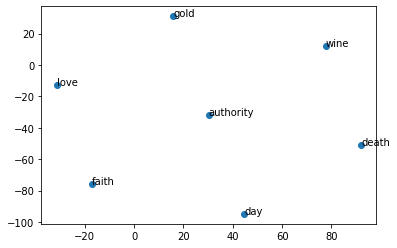

Epoch: 1 loss: 0.048147398978471756
  gold: carries, serve, replied, born, straws
  authority: heavenly, up, forgets, sin, winkst
  wine: lodging, carries, prerogative, odd, plaster
  death: bodes, joves, forgets, princess, field
  love: awful, humble, straws, honeycomb, beasts
  faith: beginning, clouds, enough, annual, whistle
  day: sore, assure, beyond, jarring, darest


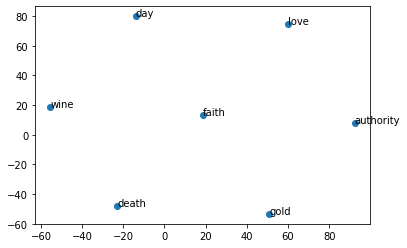

Epoch: 2 loss: 0.6449207067489624
  gold: intolerable, round, study, retired, mediterranean
  authority: retired, lodging, stuffs, came, deafness
  wine: visitor, lodging, stuffs, wert, question
  death: speech, cock, retired, making, mistress
  love: fine, dulness, deserved, scapes, endured
  faith: leapd, stuffs, should, stained, souls
  day: right, sign, laying, dulness, beside


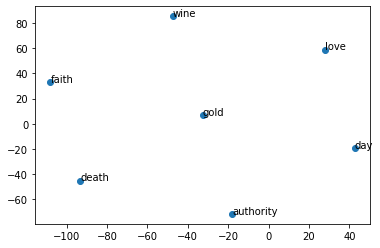

Epoch: 3 loss: 0.3346157968044281
  gold: tilth, servant, sin, , blots
  authority: advantage, honeycomb, bees, sin, winkst
  wine: servant, fortunes, question, whoreson, blots
  death: speech, goodlier, making, plaster, confounds
  love: expound, imagination, show, deceiving, task
  faith: blots, leapd, making, should, comfort
  day: cake, shape, may, warrants, winkst


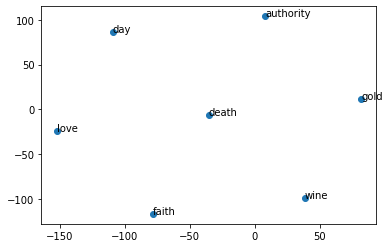

Epoch: 4 loss: 0.4189351797103882
  gold: married, few, devil, bad, 
  authority: smile, fame, grass, goddess, tended
  wine: impossible, changed, mast, young, lovely
  death: bed, moody, play, grand, swift
  love: adventure, bawling, water, habit, ferdinand
  faith: swift, grand, penetrate, spiriting, grudge
  day: winkst, quaint, wills, moving, pike


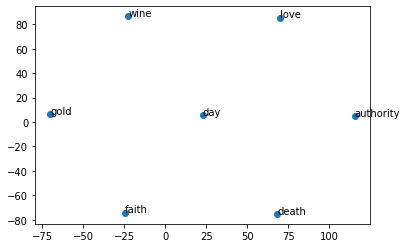

Epoch: 5 loss: 1.3394804000854492
  gold: married, succession, mong, piteous, seastorm
  authority: wombs, came, steaded, strong, seastorm
  wine: darest, grown, muddy, alonso, like
  death: pinchd, goodlier, confounds, bed, joves
  love: darest, words, villain, mans, tortoise
  faith: parsley, earthy, grand, else, basis
  day: furze, pike, laughter, birth, foison


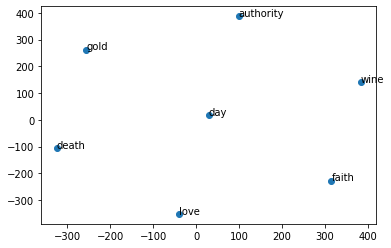

Epoch: 6 loss: 0.2723785936832428
  gold: thyself, borne, seastorm, , demanded
  authority: clouds, monstrous, goddess, winkst, seastorm
  wine: own, possesses, bowd, magistrate, marrying
  death: howld, fall, goodlier, making, gate
  love: strokedst, subdued, calldst, bawling, water
  faith: grand, against, eye, else, int
  day: almost, weeping, eye, beside, has


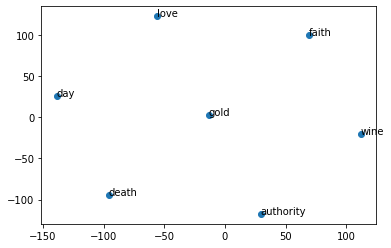

Epoch: 7 loss: 0.0014188583008944988
  gold: command, now, exactly, , bad
  authority: fair, but, strong, winkst, privately
  wine: muddy, like, endowd, marrying, privately
  death: banishd, mistress, fall, grudge, confounds
  love: deceiving, endowd, upon, strokedst, winds
  faith: clouds, eye, basis, earthy, joy
  day: serve, glosses, beside, one, has


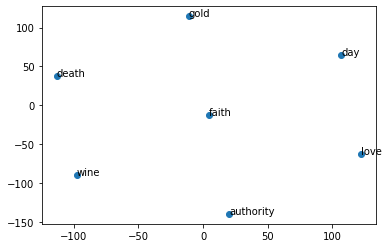

Epoch: 8 loss: 0.5151702761650085
  gold: hours, bad, seastorm, tribute, exactly
  authority: key, none, came, goddess, changed
  wine: endowd, affection, deign, scarlet, name
  death: fall, mountain, seek, tortoise, likelihood
  love: cramps, task, strokedst, bowsprit, bees
  faith: waist, hoop, earthy, basis, remembrance
  day: impossible, ways, one, potent, warrants


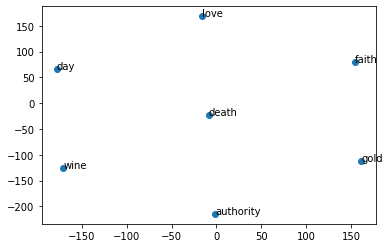

Epoch: 9 loss: 0.10493133217096329
  gold: exactly, bad, thyself, seastorm, devil
  authority: human, new, their, foul, changed
  wine: comfort, affection, extirpate, like, deign
  death: grudge, privilegio, gun, tot, trust
  love: imposter, extirpate, take, mocking, strokedst
  faith: had, purposed, lay, sword, run
  day: perils, hush, mediterranean, study, howl


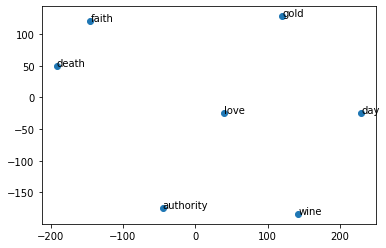

In [12]:
epochs = 10
learning_rate = 0.01
embedding_size = 65
num_neighbours = 5 

test_tokens = ["gold", "authority", "wine", "death", "love", "faith", "day"]

model = Word2Vec(vocab_size, embedding_size)

train_model(model, epochs, learning_rate, test_tokens)

# 3 Text Generation

## 3.1 Preprocessing

In [13]:
dataset = tfds.load('tiny_shakespeare', split = 'train')

In [14]:
# preprocessing data 

def make_handy(dataset):
  """ This function extracts the string tensor and converts it 
      into a string and afterwards makes the text handy to work with"""

  for data in dataset:
    # Extracting text from dictionary and get string tensor with .numpy()
    # convert string tensor to string with compat.as_text --> more handy 
    text = compat.as_text(data["text"].numpy())

  return text

In [15]:
text = make_handy(dataset)

In [16]:
# The unique characters in the file
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))

#splitting chars
chars = tf.strings.unicode_split(text, input_encoding='UTF-8')

# create Lookup 

# ids from chars
ids_from_chars = preprocessing.StringLookup(
    vocabulary=list(vocab))

# chars from ids
chars_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True)

# all IDs
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))

ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)


65 unique characters


In [17]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [18]:
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))


dataset = sequences.map(split_input_target)


for input_example, target_example in  dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())


tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)
Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [19]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [20]:
#dataset = sequences.map(split_input_target)

for input_example_batch, target_example_batch in dataset.take(1):
  print(input_example_batch)

tf.Tensor(
[[ 8  3 65 ... 43 45  3]
 [30 52 41 ... 58 44 59]
 [59  8  3 ... 41  3 59]
 ...
 [48 49 53 ...  3 42 45]
 [62 45  3 ... 59  3 58]
 [65  8  2 ... 28 21  3]], shape=(64, 100), dtype=int64)


In [21]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024


In [22]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True, 
                                   return_state=True, 
                                   name = "kevin")
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    # print(x, "inputs")
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else: 
      return x

In [23]:
model = MyModel(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

print(vocab_size)

65


In [24]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

model.summary()

(64, 100, 67) # (batch_size, sequence_length, vocab_size)
Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  17152     
_________________________________________________________________
kevin (GRU)                  multiple                  3938304   
_________________________________________________________________
dense (Dense)                multiple                  68675     
Total params: 4,024,131
Trainable params: 4,024,131
Non-trainable params: 0
_________________________________________________________________


In [25]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)


In [26]:
example_batch_loss = loss(target_example_batch, example_batch_predictions)
mean_loss = example_batch_loss.numpy().mean()
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", mean_loss)

Prediction shape:  (64, 100, 67)  # (batch_size, sequence_length, vocab_size)
Mean loss:         4.2053504


In [27]:
model.compile(optimizer='adam', loss=loss)


In [28]:
EPOCHS = 20

history = model.fit(dataset, epochs=EPOCHS)


Epoch 1/20
155/155 [==============================] - 11s 57ms/step - loss: 3.3343
Epoch 2/20
155/155 [==============================] - 10s 57ms/step - loss: 2.1239
Epoch 3/20
155/155 [==============================] - 10s 58ms/step - loss: 1.8022
Epoch 4/20
155/155 [==============================] - 10s 59ms/step - loss: 1.6071
Epoch 5/20
155/155 [==============================] - 10s 58ms/step - loss: 1.4891
Epoch 6/20
155/155 [==============================] - 10s 57ms/step - loss: 1.4072
Epoch 7/20
155/155 [==============================] - 10s 57ms/step - loss: 1.3477
Epoch 8/20
155/155 [==============================] - 10s 57ms/step - loss: 1.2960
Epoch 9/20
155/155 [==============================] - 10s 57ms/step - loss: 1.2524
Epoch 10/20
155/155 [==============================] - 10s 57ms/step - loss: 1.2042
Epoch 11/20
155/155 [==============================] - 10s 57ms/step - loss: 1.1649
Epoch 12/20
155/155 [==============================] - 10s 58ms/step - loss: 1.1183
E

In [29]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature=temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "" or "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['','[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices = skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())]) 
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits] 
    predicted_logits, states =  self.model(inputs=input_ids, states=states, 
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "" or "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

one_step_model = OneStep(model, chars_from_ids, ids_from_chars)


In [30]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()

print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)

print(f"\nRun time: {end - start}")


ROMEO:
I saw her curses that faults Marcius for the banishment
That is so study when you pardon to myself?
What, if thou wilt path the causes of them are
neither maidens sudden.

WARWICK:
Send them, as near as this shame? Yourge Marcius!

MARCIUS:
I'll be gone; the very time escapes of
Mantus to see any sharp in heaven at whit?
Here's me deserve walk. Come, living Romeo,
If the beard the appetite to len her crown
Then were condect'd in Rome: you are not well-seeming,
Bears a common friends. I love you, look that
Which dead? She is another breaks,
And wasten it with our steel again; nor Edward's charge,
Have I not been within the ground. Have we not lend them serve
Thee--not so fladiout,
To writ their patience toward men.

Nurse:
if he certain out which name I tend it.
But, sirrah, now from the dewicizer
And wilt thou live to let him he hardly.

HASTINGS:
I know they shall be thus to die.

DUKE VINCENTIO:
It is a rap our cares: somewhen is there be good;
For she shall have merel, the of